# Draw Figure 13

Figure 13. As in Figure 1, except for the mean count of JJA MCS days that experienced an MCS during a given hour (i.e., 0 – 23 UTC) averaged over 6-hourly periods—namely (a - c) 00 – 05 UTC, (d - f) 06 – 11 UTC, (g – i) 12 – 17 UTC, and (j – l) 18 – 23 UTC. The original magnitudes for columns 2 and 3 can be found in Fig. S4

## Read in the hourly data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import xarray as xr

data_dir = "../data"
analysis='mcs_days'
subset='hour_bin_month'

simulation_names = {'historical': 'HIST', 
                    'future_4p5': 'EoC 4.5', 
                    'delta_future_4p5': '$\Delta$ EoC 4.5',
                    'future_8p5': 'EoC 8.5', 
                    'delta_future_8p5': '$\Delta$ EoC 8.5'}

season_defs = {'DJF': [12, 1, 2], 
               'MAM': [3, 4, 5], 
               'JJA': [6, 7, 8],
               'SON': [9, 10, 11]}

bin_defs = {"[0, 6)": "00-05", 
            "[6, 12)": "06-11", 
            "[12, 18)": "12-17", 
            "[18, 24)": "18-23"}
    
season_years = {}
season_means = {}

for sim in simulation_names.keys():

    season_years[sim] = {}
    season_means[sim] = {}
    
    if sim in ['historical', 'future_4p5', 'future_8p5']:
        
        ds = xr.open_mfdataset(f"{data_dir}/{analysis}/{sim}_{subset}/*.nc")

        for season, season_months in season_defs.items():

            season_years[sim][season] = {}
            season_means[sim][season] = {}

            ds_season = ds.where(ds.month.isin(season_months), drop=True)

            ds_season = ds_season.sum('month')

            ds_season = ds_season.compute()

            for bin_id, bin_name in bin_defs.items():

                ds_season_bin = ds_season.sel(hour_bins=bin_id)

                assert ds_season_bin.year.size == 15
                ds_mean = ds_season_bin.sum('year') / ds_season_bin.year.size
    
                season_years[sim][season][bin_name] = ds_season_bin
                season_means[sim][season][bin_name] = ds_mean

        ds.close()
            
    else:

        for season in season_defs.keys():

            season_means[sim][season] = {}
            season_years[sim][season] = {}

            for bin_name in bin_defs.values():
            
                futr_str = sim.replace("delta_", "")
                
                season_means[sim][season][bin_name] = season_means[futr_str][season][bin_name] - season_means['historical'][season][bin_name]
                season_years[sim][season][bin_name] = None

# Draw map

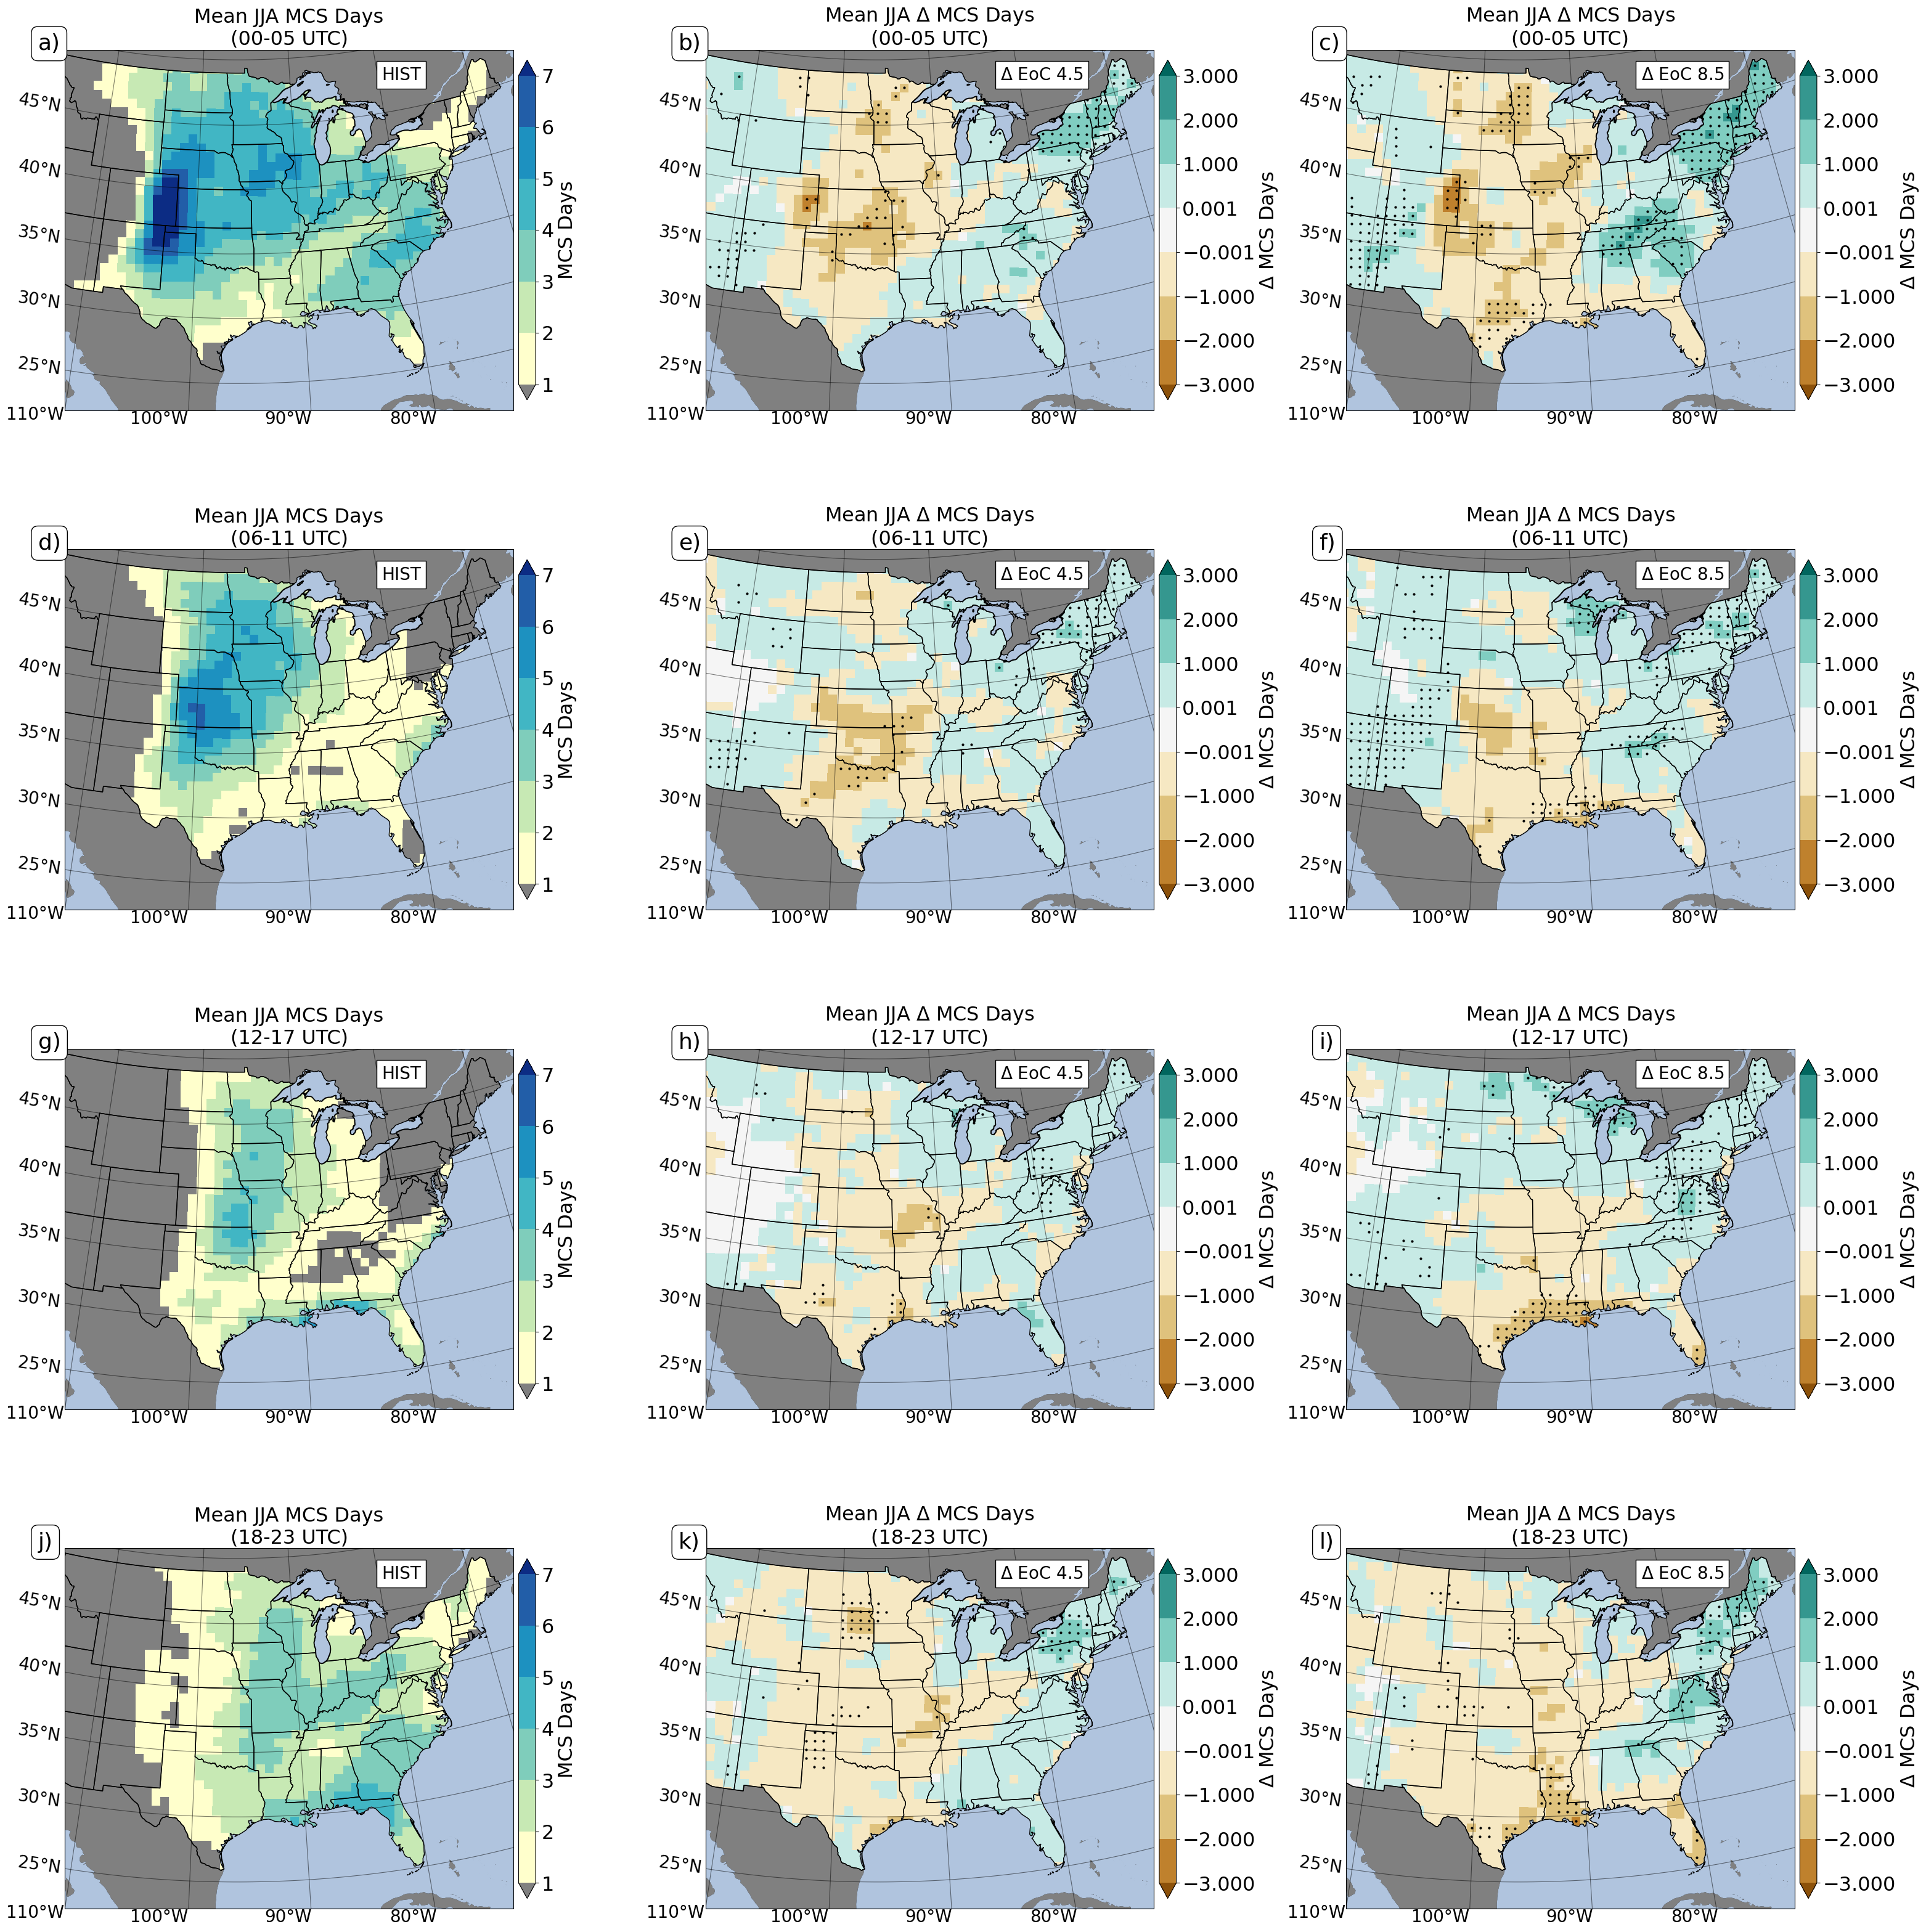

In [3]:
from mapping import setup_map, spec_ax, get_color_dict
from stats import grid_significance
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 23

color_info = get_color_dict(6)

fig = plt.figure(figsize=(38,40))

simulation_dispy = {'historical': 'HIST',
                    'delta_future_4p5': '$\Delta$ EoC 4.5',
                    'delta_future_8p5': '$\Delta$ EoC 8.5'}

f6_seas = 'JJA'

for snum, bin_name in enumerate(bin_defs.values()):

    for ax_pos, (sim_name, sim_abbr) in enumerate(simulation_dispy.items()):

        ax = spec_ax(snum, fig, 4, 3, ax_pos)

        ax = setup_map(label_num=(snum*3) + ax_pos+1, ax=ax)

        ax.annotate(f"{sim_abbr}", (0.75,0.93), 
                    xycoords='axes fraction', ha='center', va='center',
                    fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                    color='k', zorder=25)

        mmp = ax.pcolormesh(season_means[sim_name][f6_seas][bin_name].lon, season_means[sim_name][f6_seas][bin_name].lat, 
                            season_means[sim_name][f6_seas][bin_name]['MCS_Days'],
                            transform=ccrs.PlateCarree(), 
                            cmap=color_info[sim_name]['cmap'], norm=color_info[sim_name]['norm'], zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, shrink=0.85, extend='both', pad=0.01)
    
        if sim_name in ['historical', 'future_4p5', 'future_8p5']:
    
            ax.set_title(f"Mean {f6_seas} MCS Days\n({bin_name} UTC)")
            
            cbar.set_label(label="MCS Days")
    
        else:
            
            futr_str = sim_name.replace("delta_", "")
            
            ax.set_title(f"Mean {f6_seas} $\Delta$ MCS Days\n({bin_name} UTC)")
            
            cbar.set_label(label="$\Delta$ MCS Days")
            
            sig = grid_significance(season_years[futr_str][f6_seas][bin_name]['MCS_Days'].values, 
                                    season_years['historical'][f6_seas][bin_name]['MCS_Days'].values)
    
            pts_sig = np.where(sig < 0.05)
    
            ax.plot(season_means['historical'][f6_seas][bin_name].lon.values[pts_sig],
                    season_means['historical'][f6_seas][bin_name].lat.values[pts_sig],
                    transform=ccrs.PlateCarree(), zorder=5, linestyle='None', 
                    marker='.', color='k', ms=4)
        
        ax.spines['geo'].set_zorder(24)
    
#plt.savefig("Figure_13.png", dpi=200, bbox_inches='tight')

# Draw supplemental version

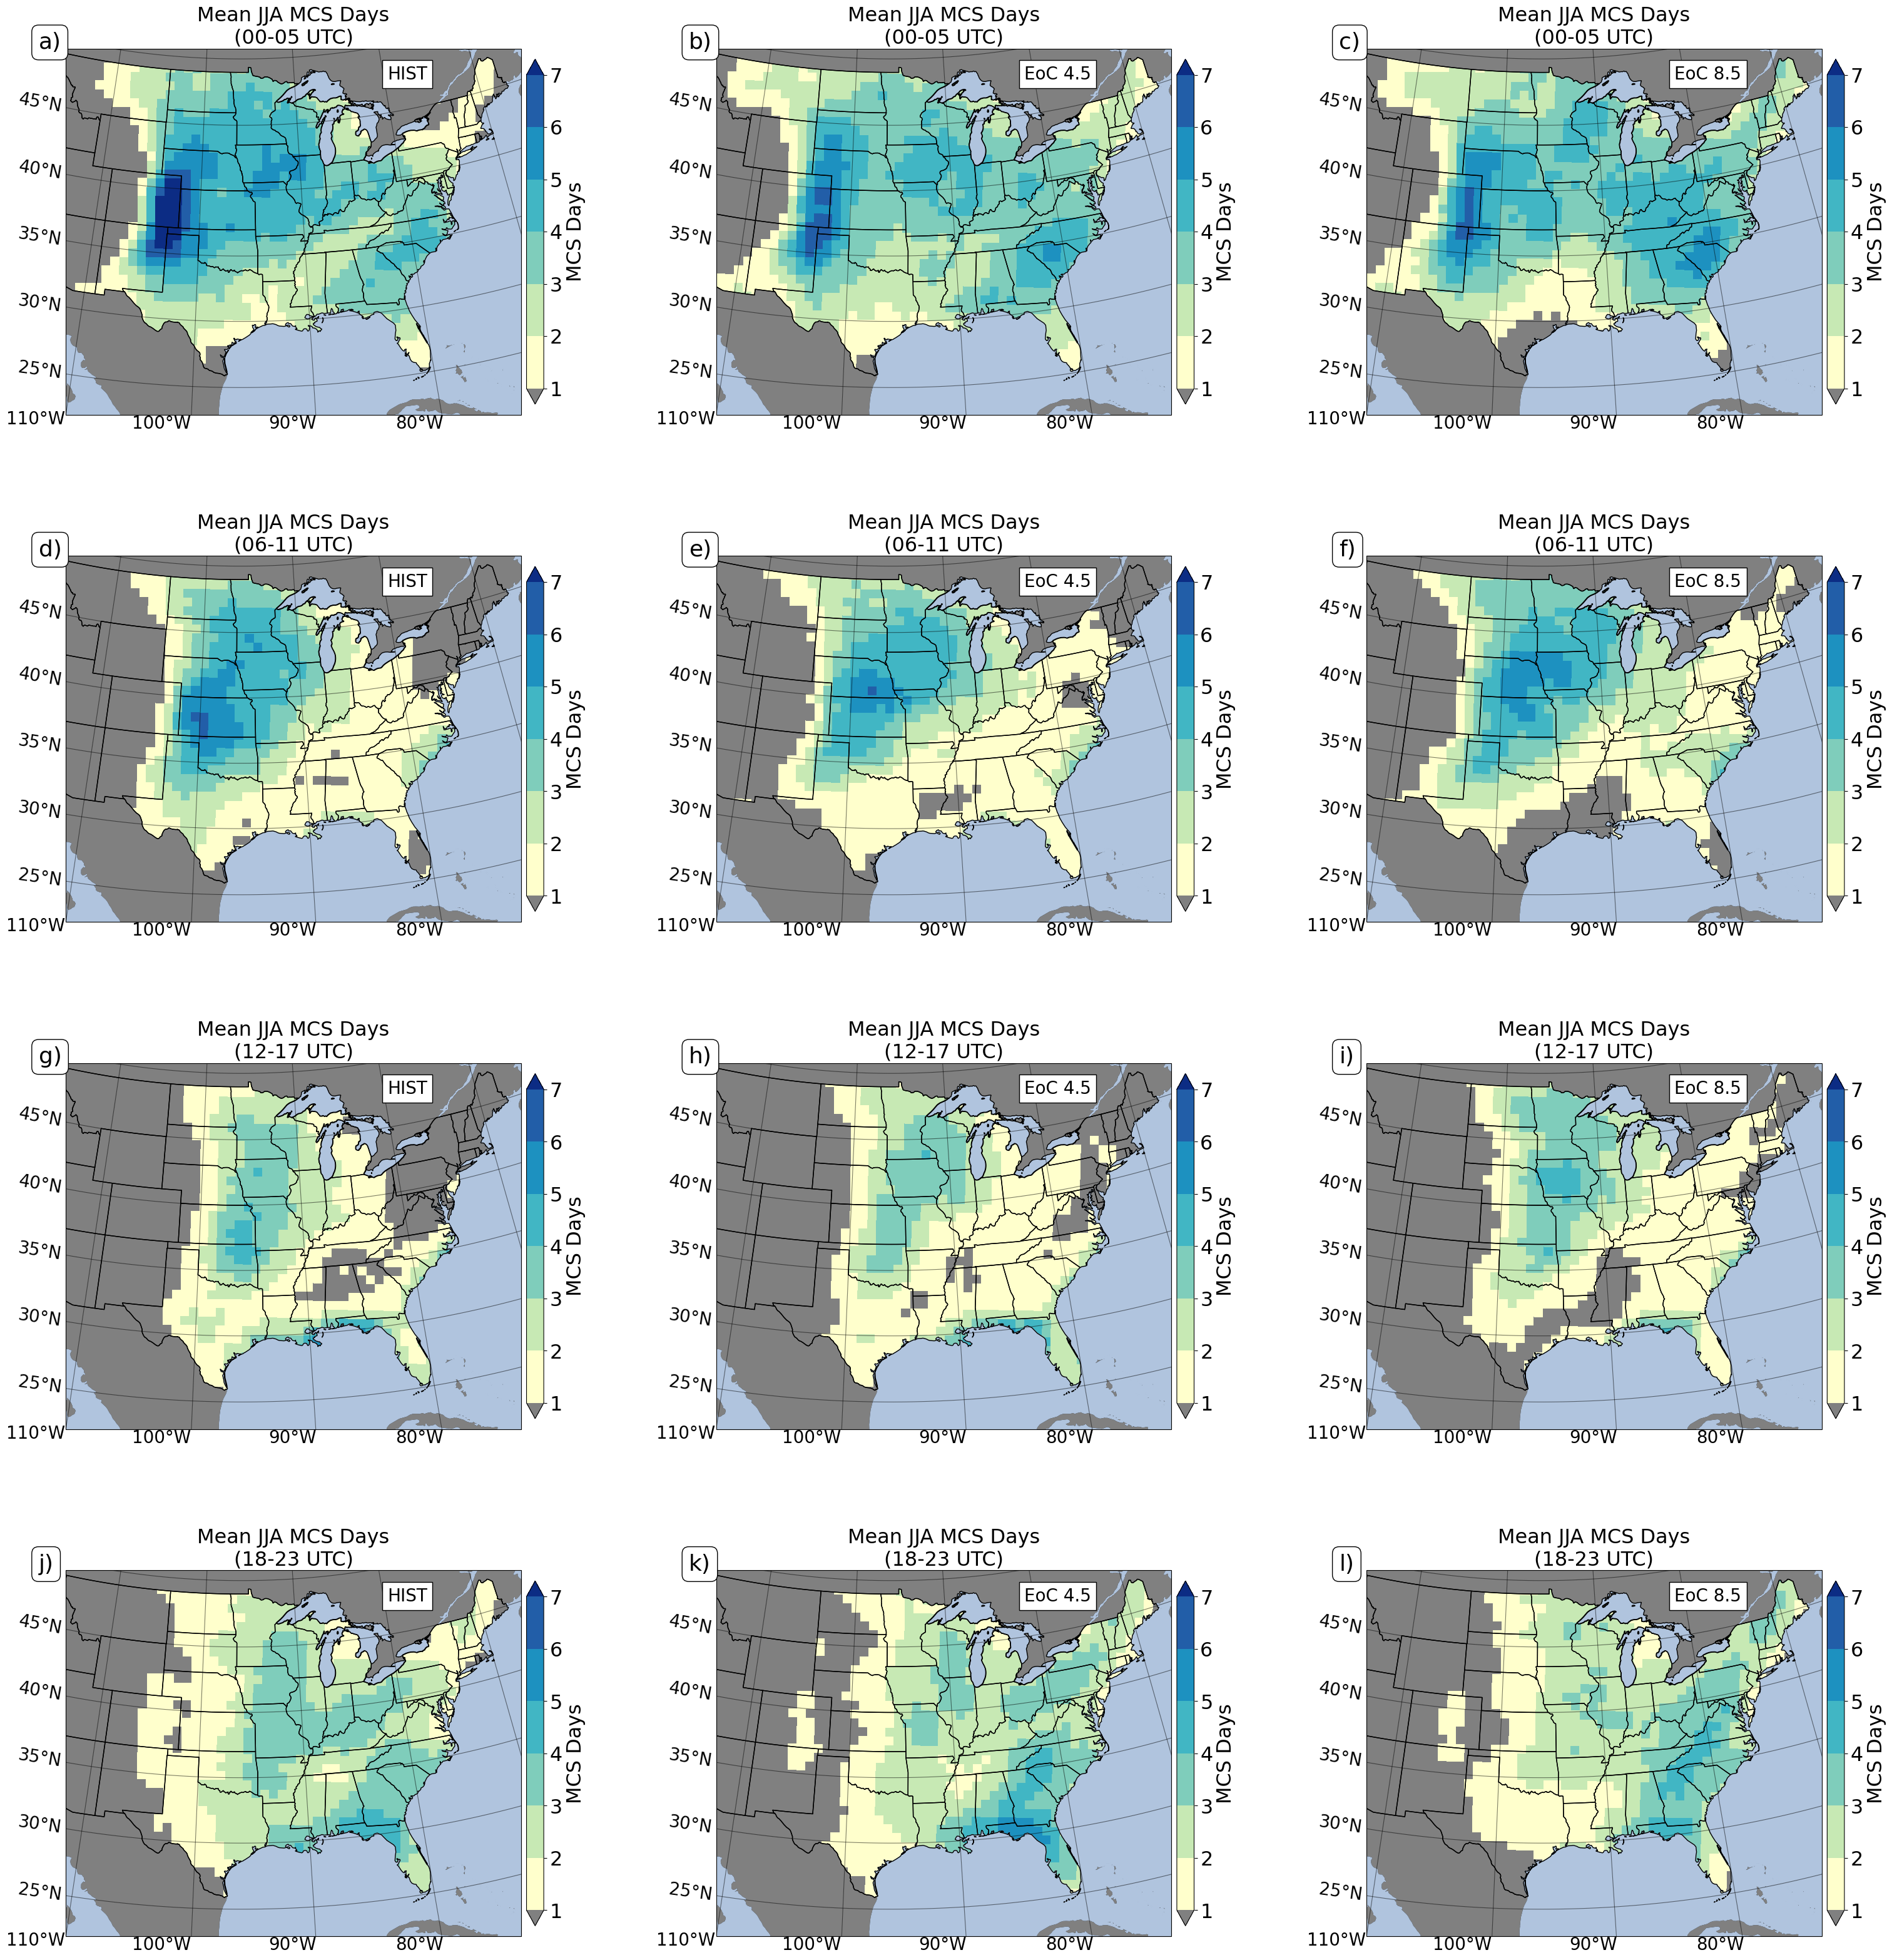

In [4]:
from mapping import setup_map, spec_ax, get_color_dict
from stats import grid_significance
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 23

color_info = get_color_dict(6)

fig = plt.figure(figsize=(38,40))

simulation_dispy = {'historical': 'HIST',
                    'future_4p5': 'EoC 4.5',
                    'future_8p5': 'EoC 8.5'}

f6_seas = 'JJA'

for snum, bin_name in enumerate(bin_defs.values()):

    for ax_pos, (sim_name, sim_abbr) in enumerate(simulation_dispy.items()):

        ax = spec_ax(snum, fig, 4, 3, ax_pos)

        ax = setup_map(label_num=(snum*3) + ax_pos+1, ax=ax)

        ax.annotate(f"{sim_abbr}", (0.75,0.93), 
                    xycoords='axes fraction', ha='center', va='center',
                    fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                    color='k', zorder=25)

        mmp = ax.pcolormesh(season_means[sim_name][f6_seas][bin_name].lon, season_means[sim_name][f6_seas][bin_name].lat, 
                            season_means[sim_name][f6_seas][bin_name]['MCS_Days'],
                            transform=ccrs.PlateCarree(), 
                            cmap=color_info[sim_name]['cmap'], norm=color_info[sim_name]['norm'], zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, shrink=0.85, extend='both', pad=0.01)
    
        ax.set_title(f"Mean {f6_seas} MCS Days\n({bin_name} UTC)")
        
        cbar.set_label(label="MCS Days")
        
        ax.spines['geo'].set_zorder(24)
    
#plt.savefig("Figure_S11.png", dpi=200, bbox_inches='tight')